# The Economic Costs of Conflict
### Abadie & Gardeazabel

This notebook reproduces the weights from the 2003 paper "The Economic Costs of Conflict: A Case Study of the Basque Country" by Alberto Abadie and Javier Gardeazabal. The study data is contained in the file `../data/basque.csv` (more detailed information on this dataset is available on page 2 of the ``R`` ``synth`` package documentation [here](https://cran.r-project.org/web/packages/Synth/Synth.pdf)).

In [2]:
import pandas as pd
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [100]:
def read_and_clean_nz_data():
    file_path = '../data/regional-gross-domestic-product-year-ended-march-2023.csv'
    df = pd.read_csv(file_path)
    df_cleaned = df[['Period', 'Data_value', 'MAGNTUDE','Subject', 'Group', 'Series_title_2', 'Series_title_3']]    
    rv = df_cleaned.rename(columns={
    'Series_title_3': 'Industry',
    'Series_title_2': 'Region',
    'Data_value': 'value'
    }).drop(columns=['Subject'], axis=1).copy(deep=True)
    rv['Industry'].fillna('Total', inplace=True)
    rv['Period'] = rv['Period'].astype(int)

    return rv

def read_and_clean_nz_population_data():
    spreadsheet_path = '../data/regional-gross-domestic-product-year-ended-march-2023.xlsx'
    table_3 = pd.read_excel(spreadsheet_path, sheet_name='Table 3')
    start_row = table_3.index[table_3.iloc[:, 0] == "Region"].tolist()[0]

    # Load the data again from the correct starting row, and set the header accordingly
    table_3_data = pd.read_excel(spreadsheet_path, sheet_name='Table 3', skiprows=start_row)

    # Rename the columns to reflect the years correctly
    table_3_data.columns = ['Region'] + table_3_data.iloc[0, 1:].tolist()

    # Drop the first two rows as they are headers
    table_3_data = table_3_data.drop([0, 1]).reset_index(drop=True)

    # Keep only regions and the total for the country, exclude island totals
    regions_to_keep = [
        'Northland', 'Auckland', 'Waikato', 'Bay of Plenty', 'Gisborne', "Hawke's Bay",
        'Taranaki', 'Manawatū-Whanganui', 'Wellington' ,'Total North Island',
        'Tasman / Nelson(2)', 'Marlborough', 'West Coast', 'Canterbury(3)', 'Otago'
        'Southland', 'Total South Island', 'Total New Zealand'
    ]
    # Filter the dataframe
    filtered_data = table_3_data[table_3_data['Region'].isin(regions_to_keep)]
    population_df = pd.melt(filtered_data, id_vars=['Region'], var_name='Year', value_name='Population')
    population_df['Year'] = population_df['Year'].astype(str).str.replace(r'\D', '', regex=True)
    
    # Convert 'Year' to integers
    population_df['Population'] = population_df['Population'].astype(float)
    population_data_cleaned = population_df.replace({
    'Region': {
        'Manawatū-Whanganui': 'Manawatu-Whanganui',
        'Tasman / Nelson(2)': 'Tasman/Nelson',
        'Canterbury(3)': 'Canterbury',
        'Total New Zealand': 'New Zealand'
    }
    })
    population_data_cleaned['Year'] = population_data_cleaned['Year'].apply(lambda x: str(x)[:-1] if len(str(x)) == 5 else str(x))
    population_data_cleaned['Year'] = population_data_cleaned['Year'].astype(int)
    return population_data_cleaned


Sectoral shares of GDP: agriculture, administration, construction, education, financial, food, health, information, manufacturing, occupation, professional, public services, rental, retail, transport, wholesale, and others (averaged between 2006 and 2010)


Percentage of the population with a tertiary educational level (averaged between 2007 and 2010)

In [107]:
def read_and_merge_nz_data():
    df = read_and_clean_nz_data()
    pop = read_and_clean_nz_population_data()
    df_wide = pd.pivot_table(df, index=['Period', 'Region'], columns='Industry', values='value').reset_index()
    df_wide.rename(columns={'Period': 'Year'}, inplace=True)
    df_wide.drop(columns=['Total All Industries'], inplace=True)
    return df_wide



In [102]:
pop.dtypes

Region         object
Year            int32
Population    float64
dtype: object

In [105]:
merged_df = pd.merge(df_wide, pop, on=['Year', 'Region'], how='outer')
merged_df.to_csv('merged.csv')

In [106]:
merged_df

,Year,Region,Accommodation,Administrative and Support Services,Agriculture,Construction,Education and Training,"Electricity, Gas, Water, and Waste services",Financial and Insurance Services,Food and beverage services,...,Primary Manufacturing,"Professional, Scientific, and Technical Services",Public Administration and Safety,"Rental, Hiring and Real Estate Services",Retail Trade,Total,Total All Industries,"Transport, Postal and Warehousing",Wholesale Trade,Population
0,2000,Auckland,223.0,958.0,182.0,1855.0,1455.0,783.0,2124.0,442.0,...,3801.0,3472.0,997.0,2585.0,1894.0,33958.0,37716.0,2012.0,3480.0,1193800.0
1,2000,Bay of Plenty,40.0,77.0,412.0,318.0,212.0,134.0,123.0,80.0,...,824.0,235.0,151.0,388.0,302.0,23920.0,5430.0,370.0,216.0,244000.0
2,2000,Canterbury,107.0,261.0,731.0,616.0,628.0,366.0,371.0,212.0,...,1187.0,668.0,410.0,712.0,640.0,26604.0,12215.0,710.0,673.0,493500.0
3,2000,Gisborne,6.0,13.0,99.0,55.0,53.0,11.0,11.0,11.0,...,113.0,32.0,34.0,60.0,49.0,20918.0,901.0,57.0,25.0,46300.0
4,2000,Hawke's Bay,17.0,50.0,357.0,174.0,129.0,59.0,65.0,34.0,...,809.0,130.0,107.0,193.0,164.0,24692.0,3386.0,178.0,116.0,147400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,2023,Total North Island,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76645.0,NaN,NaN,NaN,3953700.0
428,2023,Total South Island,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,70973.0,NaN,NaN,NaN,1213600.0
429,2023,Waikato,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,67028.0,NaN,NaN,NaN,516400.0
430,2023,Wellington,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,86805.0,NaN,NaN,NaN,546800.0


In [2]:

dataprep = Dataprep(
    foo=df,
    predictors=[
        "sec_agriculture",
        "sec_administration",
        "sec_construction",
        "sec_education",
        "sec_financial",
        "sec_food",
        "sec_health",
        "sec_information",
        "sec_manufacturing",
        "sec_ocupation",
        "sec_professional",
        "sec_public",
        "sec_rental",
        "sec_retail",
        "sec_transport",
        "sec_wholesale",
        "tertiary_per",
    ],
    predictors_op="mean",
    time_predictors_prior=range(2006, 2011),
    dependent="gdpcap",
    unit_variable="regionname",
    time_variable="year",
    treatment_identifier="Basque Country (Pais Vasco)",
    controls_identifier=[
        "Spain (Espana)",
        "Andalucia",
        "Aragon",
        "Principado De Asturias",
        "Baleares (Islas)",
        "Canarias",
        "Cantabria",
        "Castilla Y Leon",
        "Castilla-La Mancha",
        "Cataluna",
        "Comunidad Valenciana",
        "Extremadura",
        "Galicia",
        "Madrid (Comunidad De)",
        "Murcia (Region de)",
        "Navarra (Comunidad Foral De)",
        "Rioja (La)",
    ],
    time_optimize_ssr=range(1960, 1970),
)

print(dataprep)

Dataprep
Treated unit: Basque Country (Pais Vasco)
Dependent variable: gdpcap
Control units: Spain (Espana), Andalucia, Aragon, Principado De Asturias, Baleares (Islas), Canarias, Cantabria, Castilla Y Leon, Castilla-La Mancha, Cataluna, Comunidad Valenciana, Extremadura, Galicia, Madrid (Comunidad De), Murcia (Region de), Navarra (Comunidad Foral De), Rioja (La)
Time range in data: 1955.0 - 1997.0
Time range for loss minimization: range(1960, 1970)
Time range for predictors: range(1964, 1970)
Predictors: school.illit, school.prim, school.med, school.high, school.post.high, invest
Special predictors:
    `gdpcap` over `range(1960, 1970)` using `mean`
    `sec.agriculture` over `range(1961, 1970, 2)` using `mean`
    `sec.energy` over `range(1961, 1970, 2)` using `mean`
    `sec.industry` over `range(1961, 1970, 2)` using `mean`
    `sec.construction` over `range(1961, 1970, 2)` using `mean`
    `sec.services.venta` over `range(1961, 1970, 2)` using `mean`
    `sec.services.nonventa` ov

We supply the `Dataprep` object to a `Synth` object. The optimisation scheme we use is [Nelder-Mead](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html) and the starting point for the optimisation is `equal` i.e. with all weights equal. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point*.

In [3]:
synth = Synth()
synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="equal")

synth.weights()

Spain (Espana)                  0.000
Andalucia                       0.000
Aragon                          0.000
Principado De Asturias          0.000
Baleares (Islas)                0.000
Canarias                        0.000
Cantabria                       0.000
Castilla Y Leon                 0.000
Castilla-La Mancha              0.000
Cataluna                        0.851
Comunidad Valenciana            0.000
Extremadura                     0.000
Galicia                         0.000
Madrid (Comunidad De)           0.149
Murcia (Region de)              0.000
Navarra (Comunidad Foral De)    0.000
Rioja (La)                      0.000
Name: weights, dtype: float64

The synthetic control obtained from the optimisation is: $$\text{Synthetic Control} = 0.851 \times \text{Cataluna} + 0.149 \times \text{Madrid}.$$

The `path_plot` method shows the path of the treated unit and the synthetic control over time.

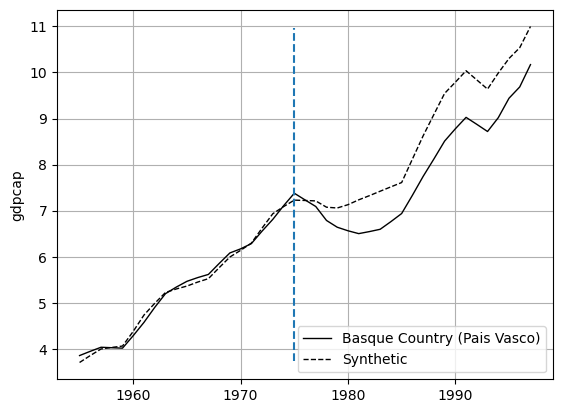

In [4]:
synth.path_plot(time_period=range(1955, 1998), treatment_time=1975)

The `gaps_plot` method shows the gaps (the difference between the treated unit and the synthetic control) over time.

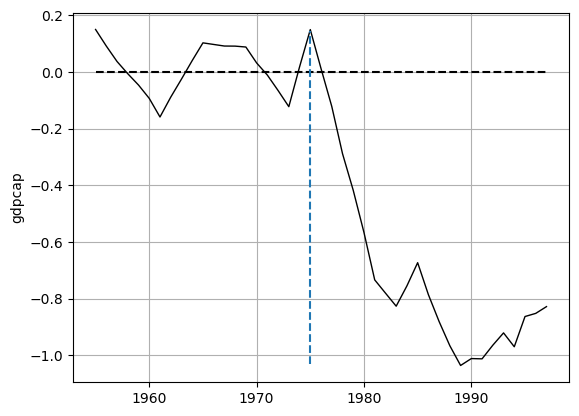

In [5]:
synth.gaps_plot(time_period=range(1955, 1998), treatment_time=1975)

Compute the average treatment effect on the treated unit (ATT) over the post-treatment time period, also returns a standard error (se).

In [6]:
synth.att(time_period=range(1975, 1998))

{'att': -0.6995653768672561, 'se': 0.07078077988529438}

The summary function gives more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [7]:
synth.summary()

,V,treated,synthetic,sample mean
school.illit,0.073,39.888,256.336,323.826
school.prim,0.120,1031.742,2730.104,2182.453
school.med,0.003,90.359,223.340,148.864
school.high,0.102,25.728,63.437,47.133
school.post.high,0.011,13.480,36.154,26.163
invest,0.000,24.647,21.583,21.445
special.1.gdpcap,0.117,5.285,5.271,3.584
special.2.sec.agriculture,0.063,6.844,6.179,21.058
special.3.sec.energy,0.156,4.106,2.760,5.252
special.4.sec.industry,0.096,45.082,37.636,22.670


We can run a Placebo test using the `PlaceboTest` class. After instantiating it, we supply the original `Dataprep` object to it as well as a synthetic control method object (our `synth` from previously) and any options that we want to supply to the synthetic control method object (the optimisation scheme and starting point for the optimisation scheme).

In [8]:
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth,
    scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
)

(1/17) Completed placebo test for Spain (Espana).
(2/17) Completed placebo test for Castilla-La Mancha.
(3/17) Completed placebo test for Cantabria.
(4/17) Completed placebo test for Principado De Asturias.
(5/17) Completed placebo test for Baleares (Islas).
(6/17) Completed placebo test for Canarias.
(7/17) Completed placebo test for Castilla Y Leon.
(8/17) Completed placebo test for Cataluna.
(9/17) Completed placebo test for Madrid (Comunidad De).
(10/17) Completed placebo test for Andalucia.
(11/17) Completed placebo test for Aragon.
(12/17) Completed placebo test for Extremadura.
(13/17) Completed placebo test for Comunidad Valenciana.
(14/17) Completed placebo test for Rioja (La).
(15/17) Completed placebo test for Murcia (Region de).
(16/17) Completed placebo test for Navarra (Comunidad Foral De).
(17/17) Completed placebo test for Galicia.
Calculating treated unit gaps.
Done.


We can plot the gaps for the treated unit as well as all the placebos in one graph using the `gaps_plot` method of the `PlaceboTest` class.

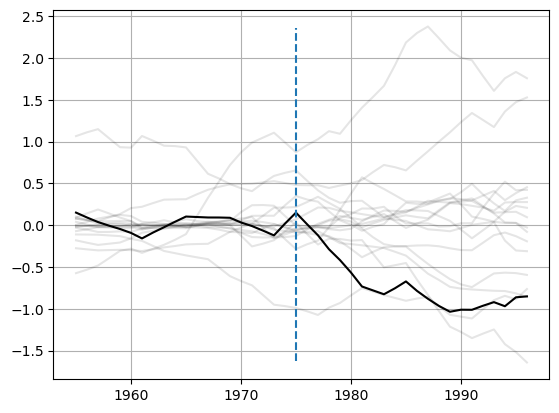

In [9]:
placebo_test.gaps_plot(
    time_period=range(1955, 1998), treatment_time=1975, exclude_units=["Spain (Espana)"]
)

We can refine the gaps plot by removing those placebos that did not have a good pre-treatment match, namely we can remove from the plot any placebo whose pre-treatment mean-square prediction error is $> n\, \times $ the pre-treatment mean-square prediction error of the treated unit. The following graph is a refined version of the previous with $n=1$ (`mspe_threshold=1`).

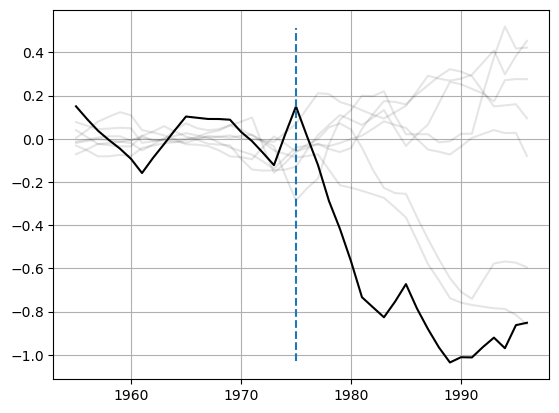

In [10]:
placebo_test.gaps_plot(
    time_period=range(1955, 1998),
    treatment_time=1975,
    exclude_units=["Spain (Espana)"],
    mspe_threshold=1,
)

We calculate $p$-value of Abadie et al's version of Fisher's exact hypothesis test for no effect of treatment null using the `pvalue` method.

In [11]:
placebo_test.pvalue(treatment_time=1975)

0.16666666666666666

We can calculate 95% confidence intervals for the treatment effect for the time periods $t=1976, 1977$. (For technical reasons involving permutation tests, we need to use all the pre-intervention time periods here rather than just the period 1960-1970 where the optimisation was carried out if we want a significance level of $\alpha=0.05$).

**(The following cell can take a while to run.)**

In [12]:
synth.confidence_interval(
    alpha=0.05,
    time_periods=[1976, 1977],
    pre_periods=list(range(1955, 1975)),
    tol=0.01,
    verbose=False,
)

,value,lower_ci,upper_ci
time,,,
1976.0,0.012254,-0.167883,0.192392
1977.0,-0.121308,-0.301446,0.072103
